# **Importing libraries**


In [ ]:
!python -m spacy download el_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.6 MB 14.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


In [ ]:
import spacy
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from html import unescape
%matplotlib inline
import glob
from datetime import datetime
from PIL import Image
import re

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Additional preparations & importing dfs**

In [ ]:
nlp = spacy.load('el_core_news_sm')
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"

In [ ]:
cv = CountVectorizer()

In [ ]:
emolex_df = pd.read_csv(filepath)

In [ ]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

In [ ]:
plt.style.use('ggplot')

In [ ]:
font = '/content/gdrive/My Drive/Colab Notebooks/Roboto-Regular.ttf'

In [ ]:
stop_word_list = list(nlp.Defaults.stop_words) + list(STOPWORDS) + ['rt', 'gt', 'https', 'http', 'co', 'κι', 'ρε', 'adamant19482884', 'amp', 'αγάπη', 'έρωτα', 'έρωτας', 'αγαπη', 'ερωτας', 'ερωτα', 'απο', 'ειμαι', 'heν', 'hiαm', 'mostς', 'oughtς', 'themselvesς', "won'tς", 'έκασε ο', 'έτερα', 'έτερων', 'ήσω', 'ίσιος', 'αγαπης', 'αλλιώ', 'ποία', 'πολύς', 'προτός', 'προχτής', 'σε ο', 'ταύ', 'τουλάχισε ο', 'τρίτος', 'τός']

In [ ]:
love = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/lovetweets.tsv", sep='\t')

In [ ]:
ladylike = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ladylike_agapi.csv")

In [ ]:
kath = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/kath_agapi.csv")

In [ ]:
love['date'] = pd.to_datetime(love['date'])

In [ ]:
love['year'] = pd.DatetimeIndex(love['date']).year
love['month'] = pd.DatetimeIndex(love['date']).month
love['day'] = pd.DatetimeIndex(love['date']).day

In [ ]:
love.drop('Unnamed: 0', inplace=True, axis=1)

# **Processing tweets**

In [ ]:
love.head(3)

,date,text,source,likes,shares,year,month,day
0,2022-06-28 19:13:38,RT @drkofans: [#agriesmelisses #ΔΚteam]\n\nη π...,"<a href=""http://twitter.com/download/android"" ...",0,15,2022,6,28
1,2022-06-28 19:13:27,RT @Drogaki1: Φυσικά και είναι μοιραία η αγάπη...,"<a href=""http://twitter.com/download/android"" ...",0,3,2022,6,28
2,2022-06-28 19:13:07,"RT @XristosStak: ""Να είναι με όποιον θέλει η Α...","<a href=""http://twitter.com/download/android"" ...",0,15,2022,6,28


In [ ]:
love.dtypes

date      datetime64[ns]
text              object
source            object
likes              int64
shares             int64
year               int64
month              int64
day                int64
dtype: object

In [ ]:
love_text = love['text'].str.replace('ά','α').str.replace("έ", "ε").str.replace('ή','η').str.replace('ί','ι').str.replace('ό','ο').str.replace('ύ','υ').str.replace('ώ','ω')

In [ ]:
love_text = love['text'].str.cat(sep = ' ').replace("amp", ' ')

In [ ]:
love_text

'RT @drkofans: [#agriesmelisses #ΔΚteam]\n\nη πιο βαθιά,αληθινή και παντοτινή αγάπη ❤️   RT @Drogaki1: Φυσικά και είναι μοιραία η αγάπη σας Αστερη μου..Αυτή η αγάπη σας μας έχει διαλύσει🥰🥰 #sasmos #ΑΑmazi   RT @XristosStak: "Να είναι με όποιον θέλει η Αργυρώ.. Εγώ και την ζωή μου θα έδινα για να είναι καλά... "\nΣε αυτή την ζωή να είστε Αστέρης,… RT @VasilikisSlut: είστε ό,τι σκέφτομαι όταν ακούω τη λέξη αγάπη #sasmos \U0001f90d   ΤΡΕΛΟΣ για την αγάπη του ρεεε #sasmos Κι εδώ βλέπουμε κόσμο που βρήκε την αγάπη σε ένα σκηνοθετημενο,στημένο ριαλιτι Τούρκου παραγωγού...🤣🤣🤣🤣Αγάπησε τον κύριο Κινητό και την προβατίνα του #survivoGR   Αναρωτιέται... υπάρχει αλήθεια στον κόσμο τέτοια αγάπη-έρωτας? Ανιδιοτελής αγάπη!!! #sasmos @LilliumLoves Βρε αγάπη μου ποιος είπε ότι είμαστε  αλάνθαστοι.Αν δεν αντιλαμβάνεσαι αυτά που γράφω δεν έχει νόημα η συζήτηση. RT @demymanolakis: Πάντα να δείχνεις καλοσύνη και αγάπη στους άλλους!\nΤα λόγια σου μπορεί να γεμίσουν τα κενά στην καρδιά κάποιου άλλου....… Φυσ

In [ ]:
doc = nlp(love['text'][1])

In [ ]:
for token in doc:
    print(token, token.lemma_)

RT RT
@Drogaki1 @Drogaki1
: :
Φυσικά φυσικά
και και
είναι είμαι
μοιραία μοιραίος
η ο
αγάπη Αγάπη
σας μου
Αστερη Αστερη
μου μου
.. ..
Αυτή αυτός
η ο
αγάπη αγάπη
σας μου
μας εγώ
έχει έχω
διαλύσει διαλύνω
🥰 🥰
🥰 🥰
# #
sasmos sasmos
# #
ΑΑmazi ΑΑmazi
   


In [ ]:
' '.join(token.lemma_ for token in doc)

'RT @Drogaki1 : φυσικά και είμαι μοιραίος ο Αγάπη μου Αστερη μου .. αυτός ο αγάπη μου εγώ έχω διαλύνω 🥰 🥰 # sasmos # ΑΑmazi  '

In [ ]:
full_doc = nlp(love_text)

In [ ]:
final_love_text = ' '.join(token.lemma_ for token in full_doc)

**Wordcloud**

In [ ]:
mask = np.array(Image.open('/content/gdrive/My Drive/Colab Notebooks/heart.png'))
mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
def one_color_func(word=None, font_size=None, 
                   position=None, orientation=None, 
                   font_path=None, random_state=None):
    h = 340 # 0 - 360
    s = 75 # 0 - 100
    l = random_state.randint(30, 75) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

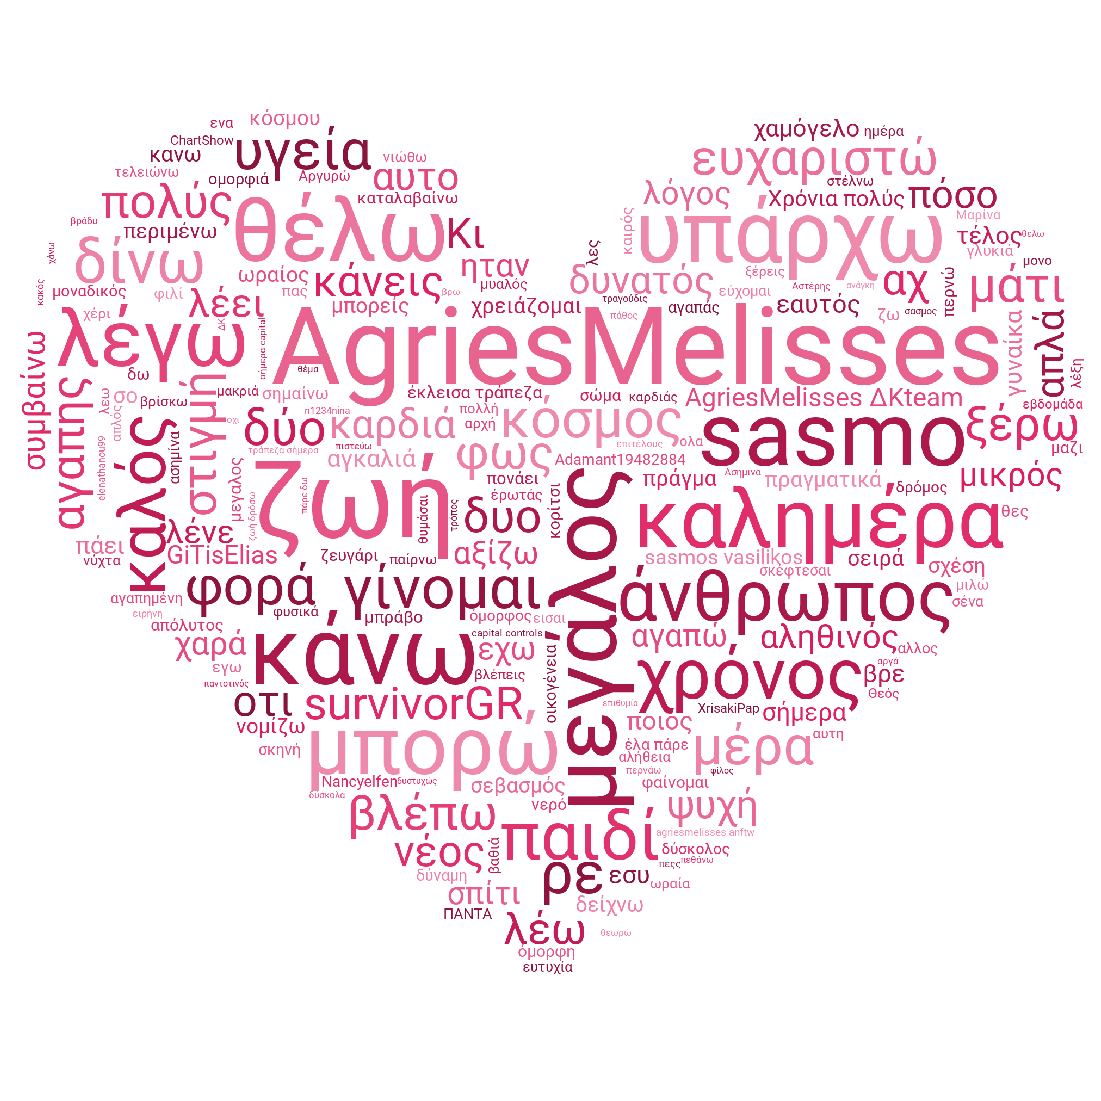

<Figure size 432x288 with 0 Axes>

In [ ]:
wordcloud = WordCloud(
    stopwords = stop_word_list, 
    font_path = font,
    background_color = 'white',
    mask=mask,
    color_func=one_color_func
    ).generate(final_love_text)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="None")
plt.axis('off')

plt.show()
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/wordcloud.png", format="png")

**Vectorizing**

In [ ]:
count_vector = cv.fit_transform(love['text'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,capital controls αντιδράσεις,controls αντιδράσεις twitter,flick_and_swish sasmos vasilikos,έκλεισα τράπεζες σήμερα,έλα πάρε δω,έμεινε έγκυος ματιά,ακούει στ όνομα,γυναίκα παντρεύτηκε πάνινη,δυνατός κατάληξη αξίζει,ζωής δρόσω agriesmelisses,κάλο ξημερώμα υγεία,καλή καρδιά ναχεις,κούκλα έμεινε έγκυος,κράτησε σένα λεπτό,ξημερώμα υγεία καλή,πάνινη κούκλα έμεινε,παντρεύτηκε πάνινη κούκλα,σήμερα capital controls,τράπεζες σήμερα capital,υγεία καλή καρδιά
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, min_df=0.01, max_df=0.95)

In [ ]:
count_vector = cv.fit_transform(love['text'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agriesmelisses,amp,gitiselias,rt,sasmos,survivorgr,έκλεισα,έρωτα,έρωτας,αγάπη,...,σήμερα,στιγμή,τράπεζες,υγεία,υπάρχει,φορά,φως,χαρά,χρόνια,όμορφη
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def my_tokenizer(doc):
            
    doc_clean = unescape(doc).lower()
    tokens = nlp(doc_clean)
    lemmatized_tokens = [token.lemma_ for token in tokens if (len(str(token.lemma_))>2)]
            
   
    return(lemmatized_tokens)

In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=16, ngram_range=(1, 1)) #, token_pattern = '\\bκυ[α-ωά-ώ]*\\b', tokenizer=my_tokenizer
count_vector = cv.fit_transform(love['text'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agriesmelisses,sasmos,ειναι,ζωή,ζωής,κάνει,καλημέρα,καλό,μάτια,μεγάλος,παιδιά,σήμερα,υγεία,υπάρχει,φως,χρόνια
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


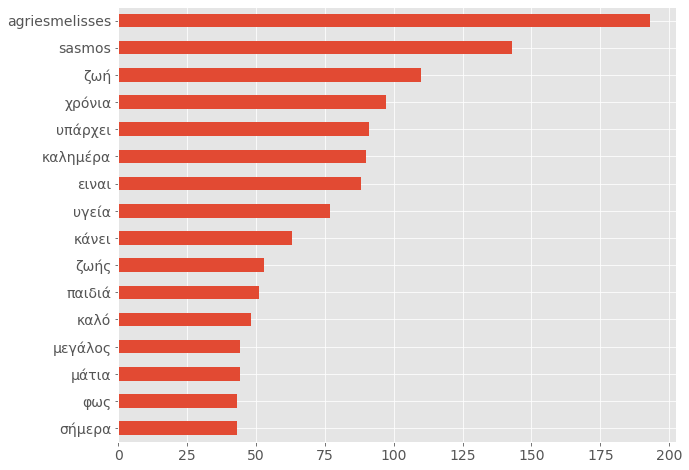

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=20, ngram_range=(2, 2) ) #token_pattern = '\\bκυ[α-ωά-ώ]*\\b') #, tokenizer=my_tokenizer)
count_vector = cv.fit_transform(love['text'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agriesmelisses anftw,agriesmelisses δκteam,capital controls,controls αντιδράσεις,sasmos alphatvgreece,sasmos vasilikos,έκλεισα τράπεζες,έλα πάρε,αντιδράσεις twitter,γυναίκα παντρεύτηκε,δρόσω agriesmelisses,ζωής δρόσω,καλή καρδιά,καλό βράδυ,καλό ξημέρωμα,κουκλίτσα αγαπημένη,πάρε δω,σήμερα capital,τράπεζες σήμερα,υγεία καλή
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


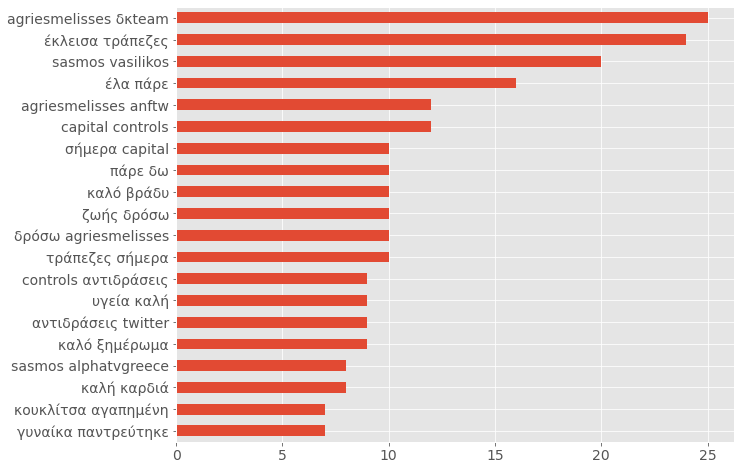

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=20, ngram_range=(3, 3) ) #token_pattern = '\\bκυ[α-ωά-ώ]*\\b') #, tokenizer=my_tokenizer)
count_vector = cv.fit_transform(love['text'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,capital controls αντιδράσεις,controls αντιδράσεις twitter,flick_and_swish sasmos vasilikos,έκλεισα τράπεζες σήμερα,έλα πάρε δω,έμεινε έγκυος ματιά,ακούει στ όνομα,γυναίκα παντρεύτηκε πάνινη,δυνατός κατάληξη αξίζει,ζωής δρόσω agriesmelisses,κάλο ξημερώμα υγεία,καλή καρδιά ναχεις,κούκλα έμεινε έγκυος,κράτησε σένα λεπτό,ξημερώμα υγεία καλή,πάνινη κούκλα έμεινε,παντρεύτηκε πάνινη κούκλα,σήμερα capital controls,τράπεζες σήμερα capital,υγεία καλή καρδιά
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


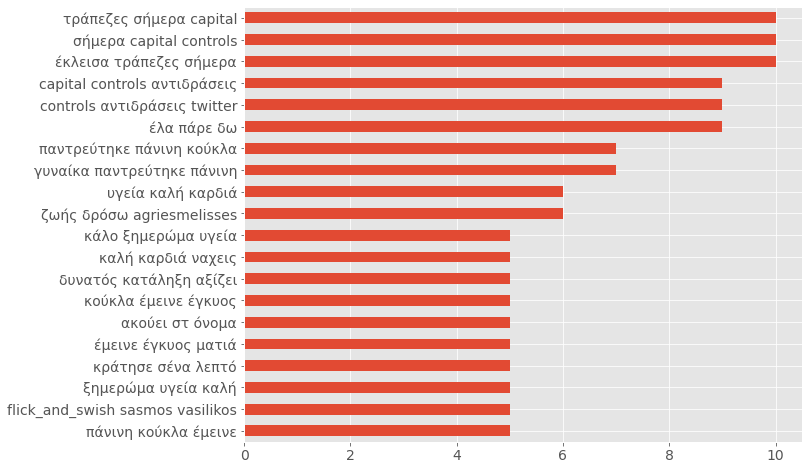

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

**Sentiment**

In [ ]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= stop_word_list,
                      ngram_range=(1, 2))

In [ ]:
matrix = vec.fit_transform(love['text'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιω', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'αποψε', 'αρα', 'αραγε', 'α

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
angry_words = emolex_df[emolex_df.Anger == 1]['word']
positive_words = emolex_df[emolex_df.Positive == 1]['word']
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']
negative_words = emolex_df[emolex_df.Negative == 1]['word']
joy_words = emolex_df[emolex_df.Joy == 1]['word']
trust_words = emolex_df[emolex_df.Trust == 1]['word']
fear_words = emolex_df[emolex_df.Fear == 1]['word']

In [ ]:
love['anger'] = wordcount_df[angry_words].sum(axis=1)
love['positive'] = wordcount_df[positive_words].sum(axis=1)
love['joy'] = wordcount_df[joy_words].sum(axis=1)
love['disgust'] = wordcount_df[disgust_words].sum(axis=1)
love['surprise'] = wordcount_df[surprise_words].sum(axis=1)
love['trust'] = wordcount_df[trust_words].sum(axis=1)
love['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
love['sadness'] = wordcount_df[sadness_words].sum(axis=1)
love['negative'] = wordcount_df[negative_words].sum(axis=1)
love['fear'] = wordcount_df[fear_words].sum(axis=1)

In [ ]:
love.set_index('date' , inplace=True)

In [ ]:
love.head(1)

,text,source,likes,shares,year,month,day,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,,,,,,
2022-06-28 19:13:38,RT @drkofans: [#agriesmelisses #ΔΚteam]\n\nη π...,"<a href=""http://twitter.com/download/android"" ...",0,15,2022,6,28,0,0,0,0,0,0,0,0,0,0


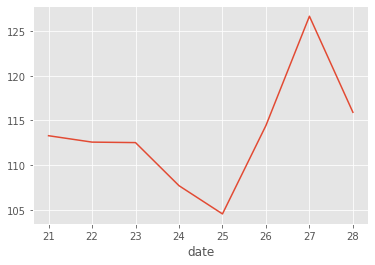

In [ ]:
love['text'].str.len().groupby(by=love.index.day).mean().plot() 

In [ ]:
love.index

DatetimeIndex(['2022-06-28 19:13:38', '2022-06-28 19:13:27',
               '2022-06-28 19:13:07', '2022-06-28 19:12:53',
               '2022-06-28 19:12:46', '2022-06-28 19:12:31',
               '2022-06-28 19:12:28', '2022-06-28 19:12:16',
               '2022-06-28 19:11:49', '2022-06-28 19:11:36',
               ...
               '2022-06-21 13:54:06', '2022-06-21 13:47:47',
               '2022-06-21 13:40:56', '2022-06-21 13:37:49',
               '2022-06-21 13:35:06', '2022-06-21 13:31:59',
               '2022-06-21 13:29:33', '2022-06-21 13:26:12',
               '2022-06-21 13:18:38', '2022-06-21 13:17:32'],
              dtype='datetime64[ns]', name='date', length=2699, freq=None)

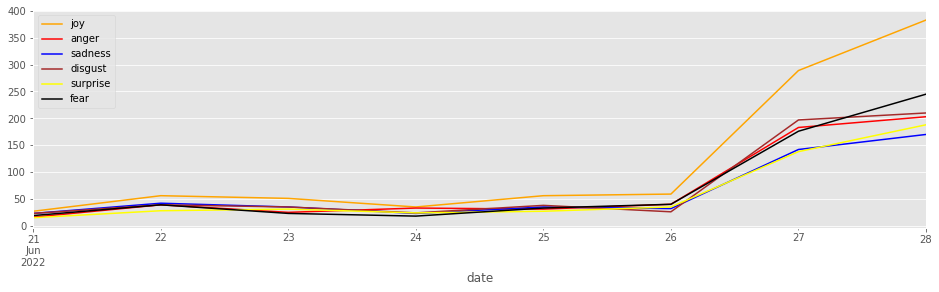

In [ ]:
ax = love['joy'].resample('D').sum().plot(figsize=(16,4), label ='joy', color = 'orange')
love['anger'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'anger', color = 'red')
love['sadness'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'sadness', color = 'blue')
love['disgust'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'disgust', color = 'brown')
love['surprise'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'surprise', color = 'yellow')
love['fear'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'fear', color = 'black').legend()


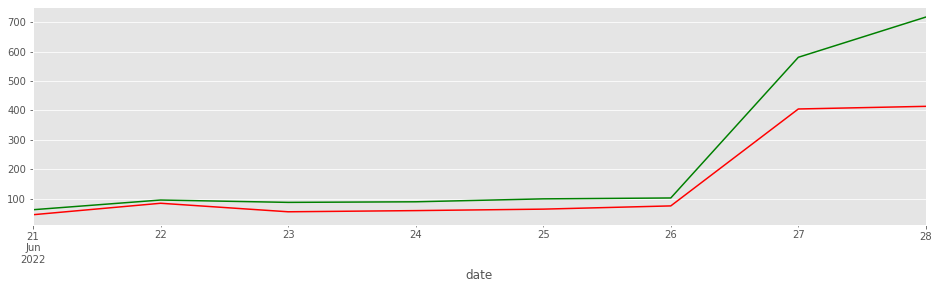

In [ ]:
ax = love['negative'].resample('D').sum().plot(figsize=(16,4), label ='negative', color = 'red')
love['positive'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'positive', color = 'green')

**More research**

In [ ]:
love_27 = love[love['day']==27]
love_28 = love[love['day']==28]

In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=16, ngram_range=(2, 2)) #, token_pattern = '\\bκυ[α-ωά-ώ]*\\b', tokenizer=my_tokenizer
count_vector = cv.fit_transform(love_27['text'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agriesmelisses anftw,agriesmelisses δκteam,capital controls,controls αντιδράσεις,sasmos alphatvgreece,sasmos vasilikos,έκλεισα τράπεζες,έλα πάρε,αντιδράσεις twitter,δκγαμος δκteam,κουκλίτσα αγαπημένη,ξημέρωμα υγεία,πάρε δω,σήμερα capital,τράπεζες σήμερα,υγεία καλή
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


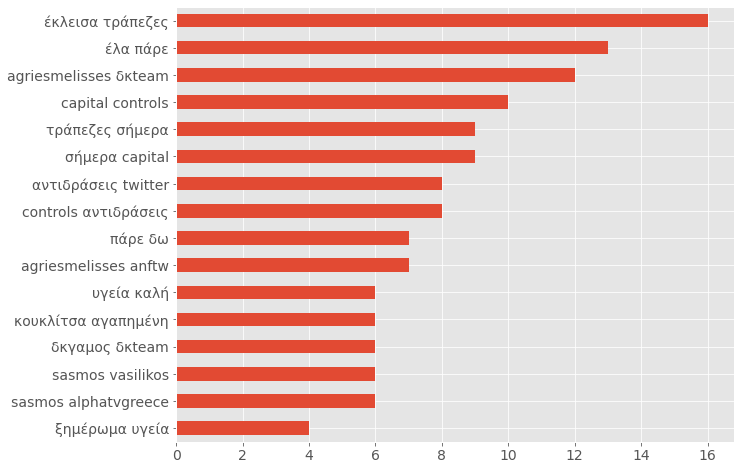

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=16, ngram_range=(2, 2)) #, token_pattern = '\\bκυ[α-ωά-ώ]*\\b', tokenizer=my_tokenizer
count_vector = cv.fit_transform(love_28['text'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,agriesmelisses δκteam,anamariapsychar χρόνια,listen live,playing now,έκλεισα τράπεζες,δρόσω agriesmelisses,ζωής agriesmelisses,ζωής δρόσω,καλημέρα υγεία,καλό βράδυ,τσίπρα παιχνίδια,υγεία επιθυμείς,υγεία ευτυχία,υπάρχει ξέρω,χρόνια υγεία,όμορφη μέρα
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


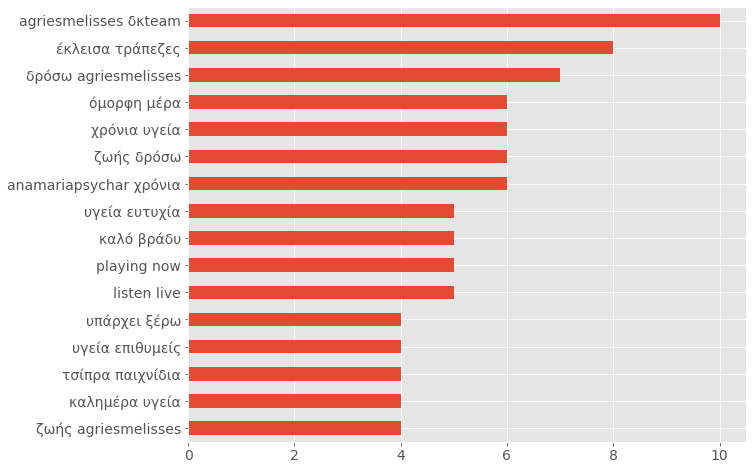

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
love[love['text'].str.contains('τράπεζες')]

,text,source,likes,shares,year,month,day,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,,,,,,
2022-06-28 11:50:01,RT @PharmaTsif: Αγάπη μου έκλεισα τις τράπεζες,"<a href=""http://twitter.com/download/android"" ...",0,24,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-28 11:22:21,"Και τι το κάνανε ο ΟΧΙ οι ""υπερήφανοι""διαπραγμ...","<a href=""http://twitter.com/download/android"" ...",12,4,2022,6,28,0,1,0,0,0,0,0,0,1,0
2022-06-28 07:56:42,"Πανελλήνια ημέρα ‘άλλος το πρωί, άλλος το βράδ...","<a href=""http://twitter.com/download/iphone"" r...",3,0,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-28 07:03:10,28/6 εφημερίδα tomanifesto:\nΒΑΛΑΒΑΝΗ:ΑΠΟΚΑΛΥ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,0,2022,6,28,2,2,0,2,1,1,1,1,3,2
2022-06-28 07:03:01,"28 Μαιου το 2015:\n\n«Αγάπη μο, έκλεισα τις τρ...","<a href=""http://twitter.com/download/iphone"" r...",4,0,2022,6,28,0,2,1,0,1,2,1,0,0,0
2022-06-28 06:58:49,"Ώστε το ""αγάπη μου έκλεισα τις τράπεζες"" το εί...","<a href=""http://twitter.com/download/iphone"" r...",7,0,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-28 05:38:09,@Efie_Ver_ Αγάπη μου έκλεισα τις τράπεζες..λόγ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0,0,2022,6,28,1,2,1,2,0,1,3,2,4,2
2022-06-28 02:15:18,"RT @LKleitou: «Αγάπη μου, έκλεισα τις τράπεζες...","<a href=""https://mobile.twitter.com"" rel=""nofo...",0,9,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-27 23:11:29,RT @zepposg: 27-28 Ιουνίου 2015.Η άθλια παρέα ...,"<a href=""http://twitter.com/download/android"" ...",0,4,2022,6,27,1,0,0,1,0,0,0,0,1,0


In [ ]:
love[love['text'].str.contains('agriesmelisses')]

,text,source,likes,shares,year,month,day,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,,,,,,
2022-06-28 19:13:38,RT @drkofans: [#agriesmelisses #ΔΚteam]\n\nη π...,"<a href=""http://twitter.com/download/android"" ...",0,15,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-28 15:06:27,"[#agriesmelisses #ΔΚteam]\n\nη πιο βαθιά,αληθι...","<a href=""http://twitter.com/download/iphone"" r...",46,15,2022,6,28,0,0,0,0,0,0,0,0,0,0
2022-06-27 23:44:37,"""Γιατί εσύ, αγαπημένη, είσαι η πνοή, το οξυγόν...","<a href=""https://mobile.twitter.com"" rel=""nofo...",26,1,2022,6,27,1,2,2,1,1,1,1,1,1,2
2022-06-27 21:56:23,RT @plittaina: “τίποτα άλλο παρά εγώ και εσύ\n...,"<a href=""http://twitter.com/download/iphone"" r...",0,15,2022,6,27,0,0,0,0,0,0,0,0,0,0
2022-06-27 21:43:15,#agriesmelisses #anftw\n\nΜόνο αυτοί και η αγά...,"<a href=""http://twitter.com/download/android"" ...",19,0,2022,6,27,0,0,0,0,0,0,0,0,0,0
2022-06-27 21:12:27,“τίποτα άλλο παρά εγώ και εσύ\nτίποτα άλλο παρ...,"<a href=""http://twitter.com/download/iphone"" r...",108,15,2022,6,27,0,0,0,0,0,0,0,0,0,0
2022-06-27 14:33:33,"RT @diaphaniotissa: Κ. Καρυωτάκης, Αγάπη\n\nη ...","<a href=""http://twitter.com/download/android"" ...",0,19,2022,6,27,0,1,0,0,0,0,0,0,0,0
2022-06-28 00:23:09,Η σειρά έδωσε την ένωση τους με τον πιο όμορφο...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",60,6,2022,6,28,2,1,1,1,0,2,1,1,2,2
2022-06-27 22:24:04,RT @Catherine1Aug: #agriesmelisses Είχα καιρό ...,"<a href=""http://twitter.com/download/iphone"" r...",0,1,2022,6,27,0,0,0,0,0,0,0,0,0,0


In [ ]:
love[love['text'].str.contains('έγκυος')]

,text,source,likes,shares,year,month,day,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,,,,,,
2022-06-27 15:33:16,@Michael_TFW συν του ότι δεν είναι μόνο τα έξο...,"<a href=""http://twitter.com/download/android"" ...",0,0,2022,6,27,0,3,1,0,0,2,3,0,4,0
2022-06-23 05:33:44,Γυναίκα παντρεύτηκε πάνινη κούκλα και έμεινε «...,"<a href=""http://twitter.com/download/android"" ...",0,0,2022,6,23,0,0,1,0,0,0,0,0,0,0
2022-06-22 16:28:24,Γυναίκα παντρεύτηκε πάνινη κούκλα και έμεινε «...,"<a href=""http://publicize.wp.com/"" rel=""nofoll...",0,0,2022,6,22,0,0,1,0,0,0,0,0,0,0
2022-06-22 11:58:03,Γυναίκα παντρεύτηκε πάνινη κούκλα και έμεινε «...,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",0,0,2022,6,22,0,0,1,0,0,0,0,0,0,0
2022-06-22 10:13:05,RT @LykavitosGr: Γυναίκα παντρεύτηκε πάνινη κο...,"<a href=""http://www.wpautopublish.com"" rel=""no...",0,2,2022,6,22,0,0,1,0,0,0,0,0,0,0
2022-06-22 10:13:04,Γυναίκα παντρεύτηκε πάνινη κούκλα και έμεινε «...,"<a href=""http://www.wpautopublish.com"" rel=""no...",3,2,2022,6,22,0,0,1,0,0,0,0,0,0,0


# **Processing articles**

In [ ]:
ladylike['date'] = pd.to_datetime(ladylike['date'])
ladylike.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
ladylike['body'] = ladylike['body'].str.replace("/4834629/ladylike.gr/ros_inline_b ", ' ', regex=True)
ladylike['body'] = ladylike['body'].str.replace("\d+", ' ', regex=True)

In [ ]:
kath['date'] = pd.to_datetime(kath['date'])
kath.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
kath['body'] = kath['body'].str.replace("000", ' ', regex=True)

**Ladylike analysis**

In [ ]:
ladylike_text = ladylike['body'].str.cat(sep = ' ').replace("amp", ' ')

In [ ]:
doc = nlp(ladylike['body'][1])

In [ ]:
for token in doc:
    print(token, token.lemma_)

   
Η ο
περίοδος περίοδος
πριν πριν
το ο
καλοκαίρι καλοκαίρι
( (
και και
πιο πιο
συγκεκριμένα συγκεκριμένα
πριν πριν
φύγεις φύγεις
για για
διακοπές διακοπή
) )
είναι είμαι
ιδανική ιδανικός
, ,
από από
άποψη άποψη
timing timing
, ,
αν αν
θέλεις θέλη
να να
κάνεις κάνεις
μία ένας
αλλαγή αλλαγή
στα σε ο
μαλλιά μαλλιά
σου σου
- -
είτε είτε
αυτή αυτός
αφορά αφορώ
το ο
χρώμα χρώμα
τους μου
, ,
είτε είτε
το ο
κούρεμά κούρεμά
σου σου
, ,
είτε είτε
και και
τα ο
δύο δύο
μαζί μαζί
. .
Η ο
Charlize Charlize
Theron Theron
για για
παράδειγμα παράδειγμα
αποφάσισε αποφασίζω
να να
κάνει κάνω
και και
τα ο
δύο δύο
. .
Πριν πριν
λίγες λίγος
μέρες μέρα
την ο
είδαμε είδαμε
να να
κάνει κάνω
το ο
ντεμπούτο ντεμπούτο
της μου
αφενός αφενός
με με
μία ένας
νέα νέος
, ,
μαύρη μαύρη
απόχρωση απόχρωση
στα σε ο
μαλλιά μαλλιά
της μου
που που
κομπόζαρε κομπόζαρε
τέλεια τέλεια
με με
τα ο
πράσινα πράσινα
μάτια μάτι
και και
την ο
ανοιχτόχρωμη ανοιχτόχρωμη
επιδερμίδα επιδερμίδα
της μου
, ,
αφ’ αφ’
ετέρου ετέρου
, ,
μ’ μ’
έν

In [ ]:
' '.join(token.lemma_ for token in doc)

'  ο περίοδος πριν ο καλοκαίρι ( και πιο συγκεκριμένα πριν φύγεις για διακοπή ) είμαι ιδανικός , από άποψη timing , αν θέλη να κάνεις ένας αλλαγή σε ο μαλλιά σου - είτε αυτός αφορώ ο χρώμα μου , είτε ο κούρεμά σου , είτε και ο δύο μαζί . ο Charlize Theron για παράδειγμα αποφασίζω να κάνω και ο δύο . πριν λίγος μέρα ο είδαμε να κάνω ο ντεμπούτο μου αφενός με ένας νέος , μαύρη απόχρωση σε ο μαλλιά μου που κομπόζαρε τέλεια με ο πράσινα μάτι και ο ανοιχτόχρωμη επιδερμίδα μου , αφ’ ετέρου , μ’ ένας κούρεμα που πραγματικά δεν περιμέναμε να δούμε να υιοθετεί : ο mixie cut . αυτός ο φορά , είμαι ο Lily James που δίνω ο # hairinspo ο ημέρα .         \t\t\t\t\t\t\t\t\t\t\t  ( ( ) {   ( \' \' ) ; } ) ; \t\t\t\t\t\t\t\t\t\t         ο ηθοποιός που πριν από αρκετός μήνας κάνω ο μεγάλος ανατροπή σε ο χρώμα ο μαλλία μου , αποφασίζω από καστανόξανθη να γίνομαι μελαχρινός , υιοθετώντας ένας σκούρα καστανή - μαύρη απόχρωση σε ο hair look μου , αυτός ο φορά αποφασίζω να κάνω ένας αλλαγή σε ο κούρεμά μου .

In [ ]:
full_doc = nlp(ladylike_text)

In [ ]:
final_ladylike_text = ' '.join(token.lemma_ for token in full_doc)

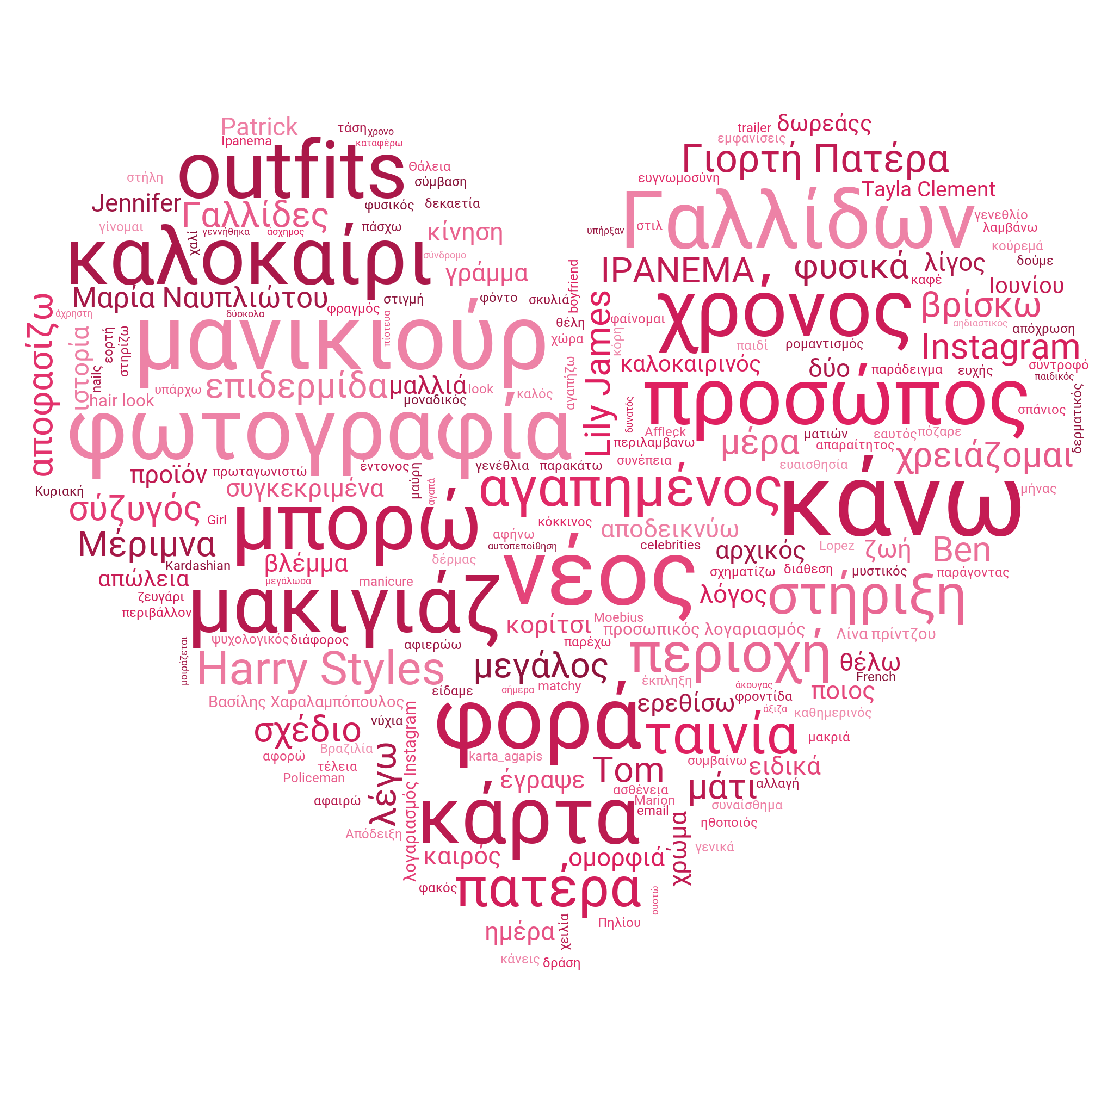

In [ ]:
wordcloud = WordCloud(
    stopwords = stop_word_list, 
    font_path = font,
    background_color = 'white',
    mask=mask,
    color_func=one_color_func
    ).generate(final_ladylike_text)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="None")
plt.axis('off')

plt.show()

In [ ]:
count_vector = cv.fit_transform(ladylike['body'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,celebrities αφιερώσει,hair look,harry styles,lily james,tayla clement,αφιερώσει μανικιούρ,βασίλης χαραλαμπόπουλος,γιορτή πατέρα,θέλεις κάνεις,κάρτα αγάπης,κόκκινο χαλί,λίγες μέρες,μαρία ναυπλιώτου,ματιών χειλιών,μαύρη απόχρωση,νέο hair
0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,4,0,0,0,0,1,0,1,2,0,0,2,2
2,2,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, min_df=0.01, max_df=0.95)

In [ ]:
count_vector = cv.fit_transform(ladylike['body'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,accounts,affleck,aka,all,allergist,and,art,artist,bachik,bangs,...,χώρα,χώρες,χώρο,ψάξιμο,ψέματα,ψυχοκοινωνική,ψυχολογική,ψυχολόγοι,ωραίο,ώρα
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=16, ngram_range=(2, 2)) #, token_pattern = '\\bκυ[α-ωά-ώ]*\\b', tokenizer=my_tokenizer
count_vector = cv.fit_transform(ladylike['body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,celebrities αφιερώσει,hair look,harry styles,lily james,tayla clement,αφιερώσει μανικιούρ,βασίλης χαραλαμπόπουλος,γιορτή πατέρα,θέλεις κάνεις,κάρτα αγάπης,κόκκινο χαλί,λίγες μέρες,μαρία ναυπλιώτου,ματιών χειλιών,μαύρη απόχρωση,νέο hair
0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,4,0,0,0,0,1,0,1,2,0,0,2,2
2,2,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


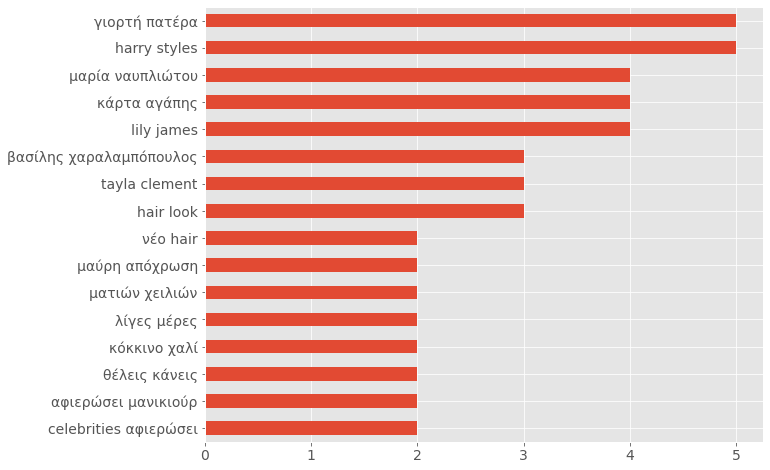

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
matrix = vec.fit_transform(ladylike['body'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιω', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'αποψε', 'αρα', 'αραγε', 'α

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
ladylike['anger'] = wordcount_df[angry_words].sum(axis=1)
ladylike['positive'] = wordcount_df[positive_words].sum(axis=1)
ladylike['joy'] = wordcount_df[joy_words].sum(axis=1)
ladylike['disgust'] = wordcount_df[disgust_words].sum(axis=1)
ladylike['surprise'] = wordcount_df[surprise_words].sum(axis=1)
ladylike['trust'] = wordcount_df[trust_words].sum(axis=1)
ladylike['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
ladylike['sadness'] = wordcount_df[sadness_words].sum(axis=1)
ladylike['negative'] = wordcount_df[negative_words].sum(axis=1)
ladylike['fear'] = wordcount_df[fear_words].sum(axis=1)

In [ ]:
ladylike.set_index('date' , inplace=True)

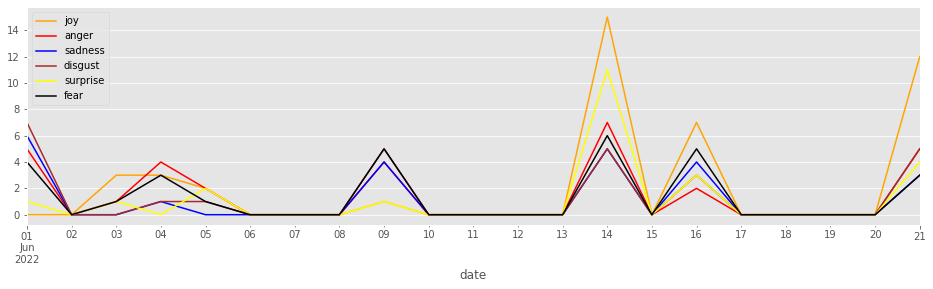

In [ ]:
ax = ladylike['joy'].resample('D').sum().plot(figsize=(16,4), label ='joy', color = 'orange')
ladylike['anger'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'anger', color = 'red')
ladylike['sadness'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'sadness', color = 'blue')
ladylike['disgust'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'disgust', color = 'brown')
ladylike['surprise'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'surprise', color = 'yellow')
ladylike['fear'].resample('D').sum().plot(ax=ax, figsize=(16,4), label = 'fear', color = 'black').legend()

**Kathimerini**

In [ ]:
kath_text = kath['body'].str.cat(sep = ' ').replace("amp", ' ')

In [ ]:
doc = nlp(kath['body'][1])

In [ ]:
for token in doc:
    print(token, token.lemma_)

Η ο
κόρη κόρη
του ο
Μπρους Μπρος
Γουίλις γουίλις
και και
της ο
Ντέμι Ντέμι
Μουρ μουρ
, ,
Σκάουτ Σκάουτ
νιώθει νιώθει
ευγνωμοσύνη ευγνωμοσύνη
για για
το ο
μεγάλο μεγάλος
κύμα κύμα
αγάπης αγάπη
και και
συμπαράστασης συμπαράσταση
στον σε ο
πατέρα πατέρα
της μου
μετά μετά
την ο
αποκάλυψη αποκάλυψη
ότι ότι
πάσχει πάσχω
από από
αφασία αφασία
. .
   


In [ ]:
' '.join(token.lemma_ for token in doc)

'ο κόρη ο Μπρος γουίλις και ο Ντέμι μουρ , Σκάουτ νιώθει ευγνωμοσύνη για ο μεγάλος κύμα αγάπη και συμπαράσταση σε ο πατέρα μου μετά ο αποκάλυψη ότι πάσχω από αφασία . \xa0'

In [ ]:
full_doc = nlp(kath_text)

In [ ]:
final_kath_text = ' '.join(token.lemma_ for token in full_doc)

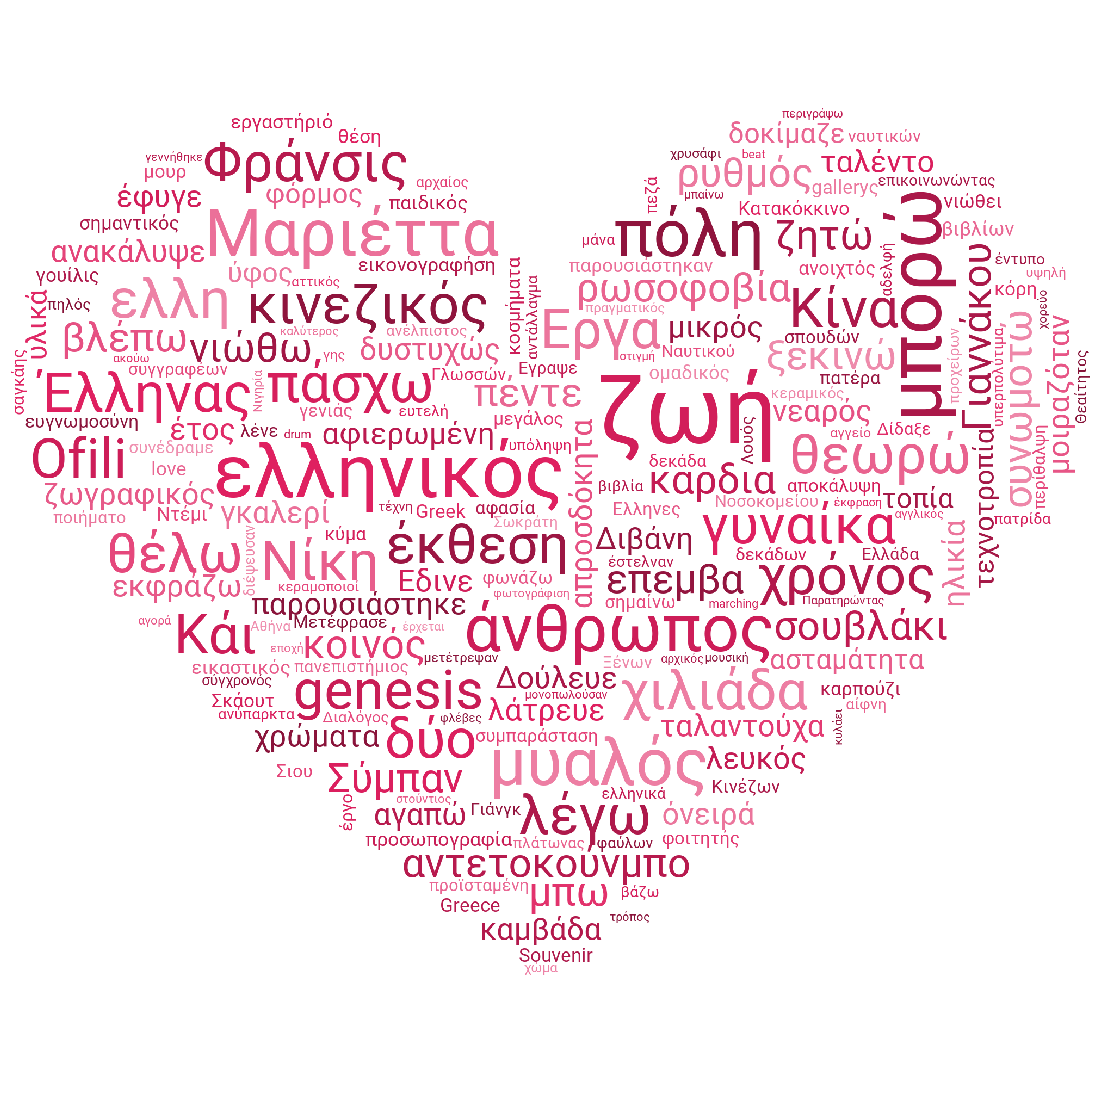

In [ ]:
wordcloud = WordCloud(
    stopwords = stop_word_list, 
    font_path = font,
    background_color = 'white',
    mask=mask,
    color_func=one_color_func
    ).generate(final_kath_text)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="None")
plt.axis('off')

plt.show()

In [ ]:
count_vector = cv.fit_transform(kath['body'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000 καρδιοχειρουργικε,ofili αντετοκούνμπο,ουκρανών πάσχουν,ουρές covid,πάολο κοέλιο,πάπρικα ελαφρώς,πάρτι δεμένη,πάσης αλβανίας,πάσχουν ασθένεια,πέντε διαφορετικές,πέντε εκατομμύρια,πέρασε ποδαρόδρομο,πίτα σφιχτά,πα επεμβα,σύμπαν συνωμοτήσει,φράνσις ofili
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, min_df=0.01, max_df=0.95)

In [ ]:
count_vector = cv.fit_transform(kath['body'])

In [ ]:
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 

results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,1951,200,2018,2019,30,33,350,aν,beat,...,χώμα,χώρα,ψηλή,ψυχή,ων,όνειρά,όρων,όψεις,ύφος,ώς
0,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
cv = CountVectorizer( stop_words= stop_word_list, max_features=16, ngram_range=(2, 2)) #, token_pattern = '\\bκυ[α-ωά-ώ]*\\b', tokenizer=my_tokenizer
count_vector = cv.fit_transform(kath['body'])
results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names()) 
results.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'tς', 've', 'wasn', 'weren', 'won', 'wouldn', 'έκασε', 'τουλάχισε'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1951 φανατικούς,ofili αντετοκούνμπο,ουκρανών πάσχουν,ουρές covid,πάολο κοέλιο,πάπρικα ελαφρώς,πάρτι δεμένη,πάσης αλβανίας,πάσχουν ασθένεια,πέντε διαφορετικές,πέντε εκατομμύρια,πέρασε ποδαρόδρομο,πίτα σφιχτά,πα επεμβα,σύμπαν συνωμοτήσει,φράνσις ofili
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2


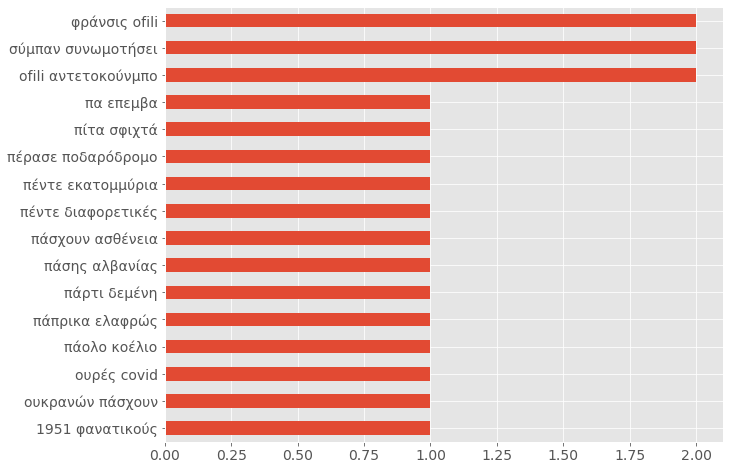

In [ ]:
results.sum(axis =0).sort_values(ascending = True).plot.barh(figsize = (10,8), fontsize = 14)

In [ ]:
matrix = vec.fit_transform(kath['body'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
kath['anger'] = wordcount_df[angry_words].sum(axis=1)
kath['positive'] = wordcount_df[positive_words].sum(axis=1)
kath['joy'] = wordcount_df[joy_words].sum(axis=1)
kath['disgust'] = wordcount_df[disgust_words].sum(axis=1)
kath['surprise'] = wordcount_df[surprise_words].sum(axis=1)
kath['trust'] = wordcount_df[trust_words].sum(axis=1)
kath['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
kath['sadness'] = wordcount_df[sadness_words].sum(axis=1)
kath['negative'] = wordcount_df[negative_words].sum(axis=1)
kath['fear'] = wordcount_df[fear_words].sum(axis=1)

In [ ]:
kath.set_index('date' , inplace=True)

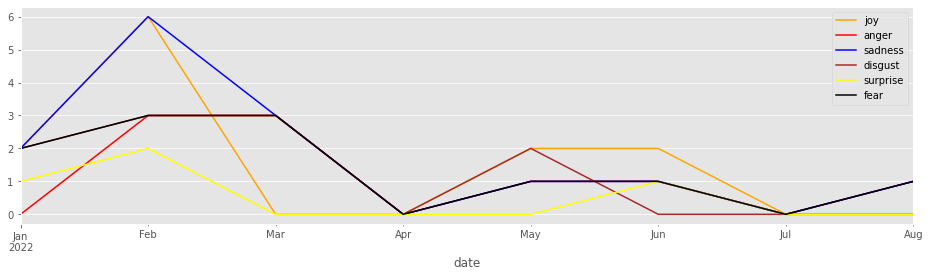

In [ ]:
ax = kath['joy'].resample('M').sum().plot(figsize=(16,4), label ='joy', color = 'orange')
kath['anger'].resample('M').sum().plot(ax=ax, figsize=(16,4), label = 'anger', color = 'red')
kath['sadness'].resample('M').sum().plot(ax=ax, figsize=(16,4), label = 'sadness', color = 'blue')
kath['disgust'].resample('M').sum().plot(ax=ax, figsize=(16,4), label = 'disgust', color = 'brown')
kath['surprise'].resample('M').sum().plot(ax=ax, figsize=(16,4), label = 'surprise', color = 'yellow')
kath['fear'].resample('M').sum().plot(ax=ax, figsize=(16,4), label = 'fear', color = 'black').legend()